In [1]:
import os
import random
import warnings
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure, feature, color, io 
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, 
    f1_score, precision_score, recall_score
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array


In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Check if a GPU is available and set it as the default device
if tf.config.list_physical_devices('GPU'):
    print("GPU is available. Using GPU.")
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


In [4]:
# Set paths to your datasets
train_dir = r"D:\Documents\cnn\Data Set 1\train"
val_dir = r"D:\Documents\cnn\Data Set 1\val"
test_dir = r"D:\Documents\cnn\Data Set 1\test"

# ImageDataGenerator for training, validation, and testing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 40002 images belonging to 2 classes.
Found 12360 images belonging to 2 classes.
Found 5227 images belonging to 2 classes.


In [5]:
# Helper function to get class names and image counts
def get_class_counts(directory):
    try:
        class_names = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
        class_counts = [len([img for img in os.scandir(os.path.join(directory, class_name)) if img.is_file()]) for class_name in class_names]
        return class_names, class_counts
    except FileNotFoundError:
        print(f"Directory not found: {directory}")
        return [], []

# Function to visualize the distribution of classes
def plot_class_distribution(directory):
    class_names, class_counts = get_class_counts(directory)
    if not class_names:
        print("No classes found in the directory.")
        return

    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=class_counts, palette='viridis')
    plt.title('Class Distribution in Training Set', fontsize=14)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Function to visualize class distribution across multiple datasets
def class_distribution_plot(data_directories):
    all_counts = []

    for directory in data_directories:
        class_names, class_counts = get_class_counts(directory)
        dataset_name = os.path.basename(directory)
        df = pd.DataFrame({'Class': class_names, 'Count': class_counts, 'Dataset': dataset_name})
        all_counts.append(df)

    if not all_counts:
        print("No valid directories to process.")
        return

    combined_df = pd.concat(all_counts, ignore_index=True)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='Count', hue='Dataset', data=combined_df, palette='viridis')
    plt.title('Class Distribution Across Datasets', fontsize=14)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

# Function to display sample images
def display_sample_images(directory, num_samples=5):
    class_names, _ = get_class_counts(directory)
    if not class_names:
        print("No classes found in the directory.")
        return

    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, len(class_names) * 3))
    axes = axes.flatten() if len(class_names) > 1 else [axes]

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        sample_images = [img.name for img in os.scandir(class_dir) if img.is_file()][:num_samples]

        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=(224, 224))
            ax = axes[i * num_samples + j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name, fontsize=12)

    plt.tight_layout()
    plt.show()

# Function to get basic dataset statistics
def get_dataset_statistics(directory):
    class_names, class_counts = get_class_counts(directory)
    total_images = sum(class_counts)

    print(f'Total number of images: {total_images}')
    print(f'Total number of classes: {len(class_names)}')

    for class_name, count in zip(class_names, class_counts):
        print(f'{class_name}: {count} images')

# Main execution
train_dir = r"D:\Documents\cnn\Data Set 1\train"
data_directories = [
    r"D:\Documents\cnn\Data Set 1\train",
    r"D:\Documents\cnn\Data Set 1\val",
    r"D:\Documents\cnn\Data Set 1\test"
]

## EDA 

In [6]:
get_dataset_statistics(train_dir)

Total number of images: 40002
Total number of classes: 2
fake: 20001 images
real: 20001 images


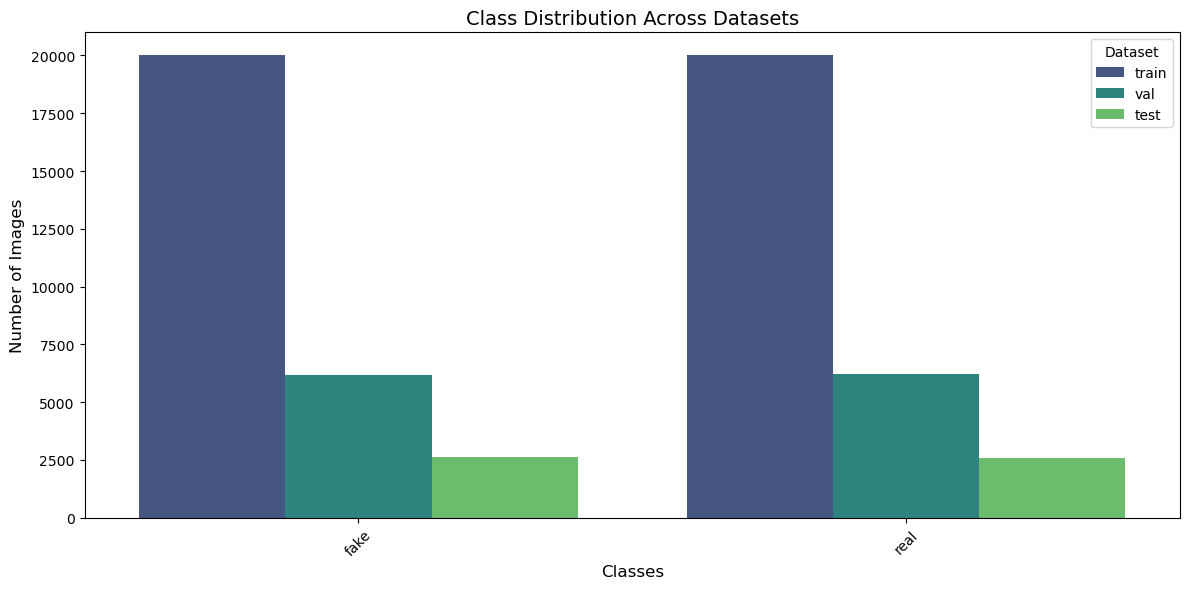

In [7]:
class_distribution_plot(data_directories)

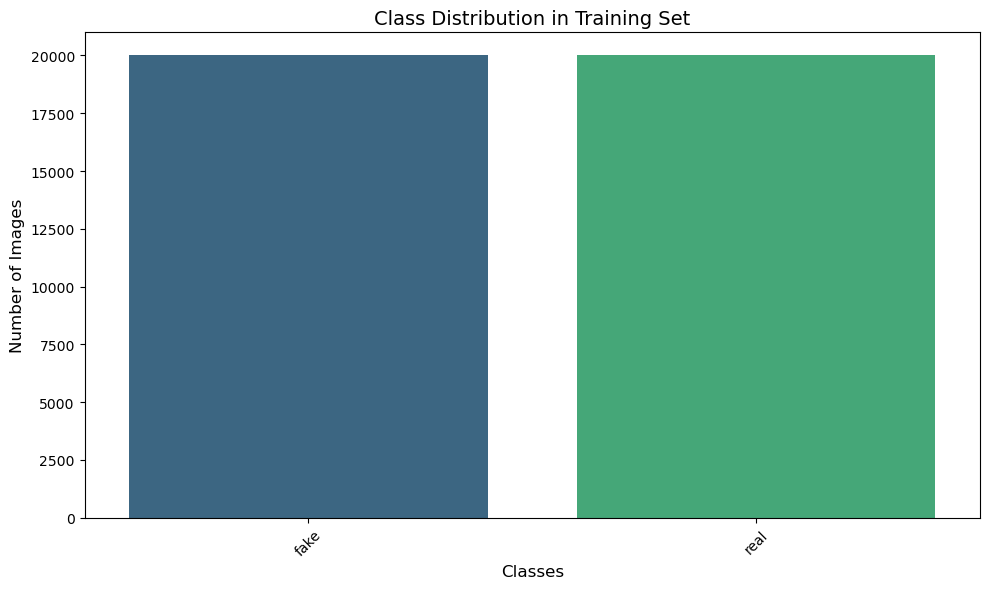

In [8]:
# Execute data exploration functions
plot_class_distribution(train_dir)

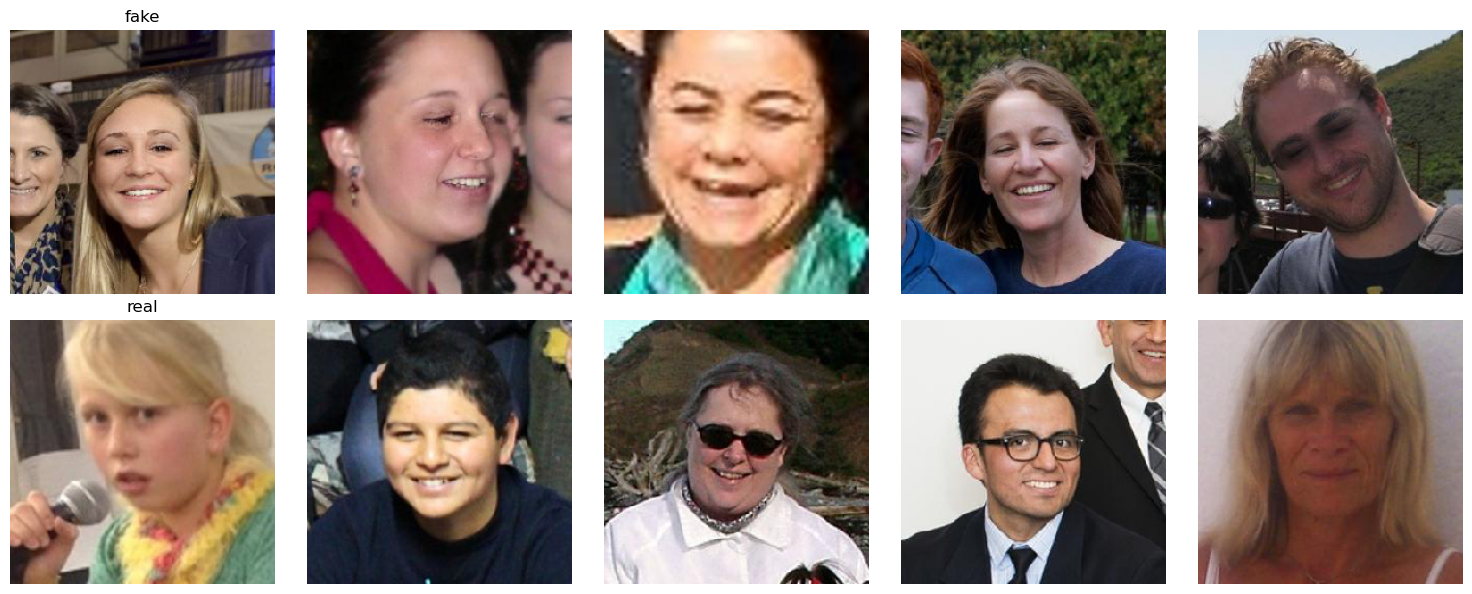

In [9]:
display_sample_images(train_dir, num_samples=5)

### Image Size Distribution

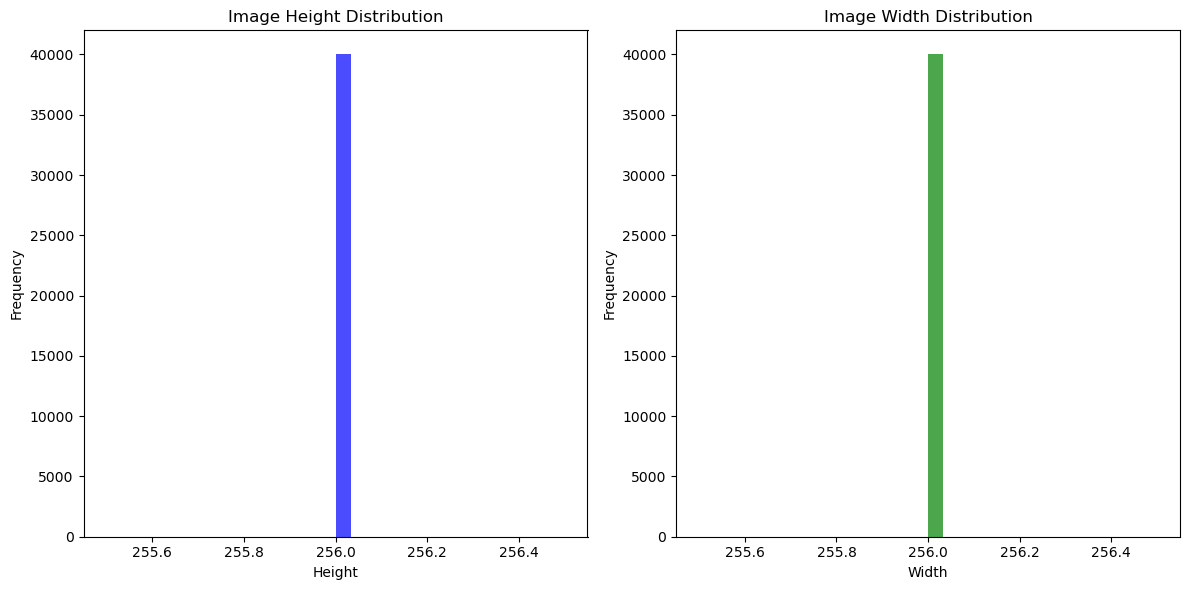

In [10]:
# Analyze the distribution of image sizes in your dataset to understand if there are any significant variations.

def analyze_image_sizes(directory):
    image_sizes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    image_sizes.append(img.shape[:2])  # (height, width)
    
    heights, widths = zip(*image_sizes)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=30, color='blue', alpha=0.7)
    plt.title('Image Height Distribution')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=30, color='green', alpha=0.7)
    plt.title('Image Width Distribution')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Analyze image sizes in the training directory
analyze_image_sizes(train_dir)

### Aspect Ratio Distribution

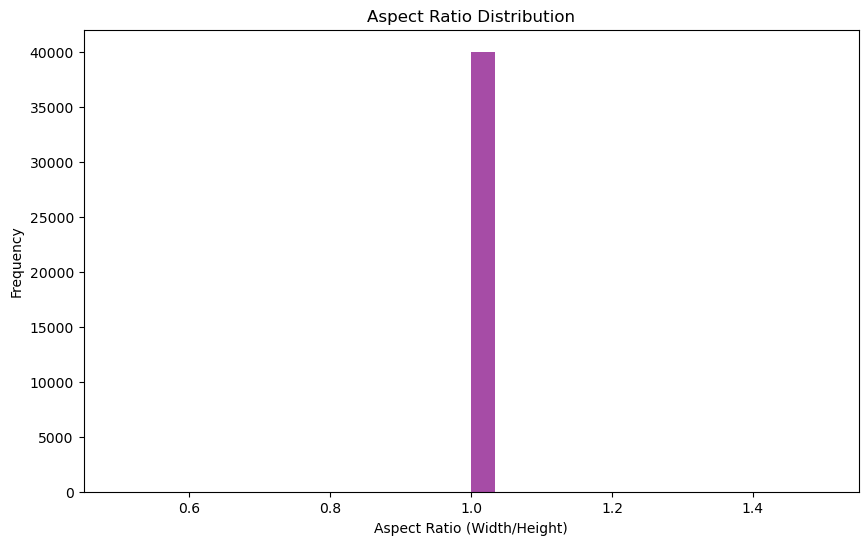

In [11]:
# Analyze the aspect ratio of images to understand if there are any common patterns.

def analyze_aspect_ratios(directory):
    aspect_ratios = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    height, width = img.shape[:2]
                    aspect_ratios.append(width / height)
    
    plt.figure(figsize=(10, 6))
    plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7)
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')
    plt.show()

# Analyze aspect ratios in the training directory
analyze_aspect_ratios(train_dir)

### Color Distribution

In [ ]:
# Analyze color distribution in the training directory analyze_color_distribution(train_dir) Analyze the color distribution in your images to understand the overall color composition.

def analyze_color_distribution(directory, batch_size=100):
    color_distributions = {'red': [], 'green': [], 'blue': []}
    files = []
    for root, _, filenames in os.walk(directory):
        for file in filenames:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                files.append(os.path.join(root, file))
    
    for i in range(0, len(files), batch_size):
        batch_files = files[i:i + batch_size]
        for img_path in batch_files:
            img = cv2.imread(img_path)
            if img is not None:
                red_channel = img[:, :, 2].flatten()
                green_channel = img[:, :, 1].flatten()
                blue_channel = img[:, :, 0].flatten()
                color_distributions['red'].extend(red_channel)
                color_distributions['green'].extend(green_channel)
                color_distributions['blue'].extend(blue_channel)
    
    # Convert lists to numpy arrays to save memory
    color_distributions['red'] = np.array(color_distributions['red'])
    color_distributions['green'] = np.array(color_distributions['green'])
    color_distributions['blue'] = np.array(color_distributions['blue'])
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.hist(color_distributions['red'], bins=30, color='red', alpha=0.7)
    plt.title('Red Channel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(color_distributions['green'], bins=30, color='green', alpha=0.7)
    plt.title('Green Channel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(color_distributions['blue'], bins=30, color='blue', alpha=0.7)
    plt.title('Blue Channel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Analyze color distribution in the training directory
analyze_color_distribution(train_dir)

### Image Contrast Distribution

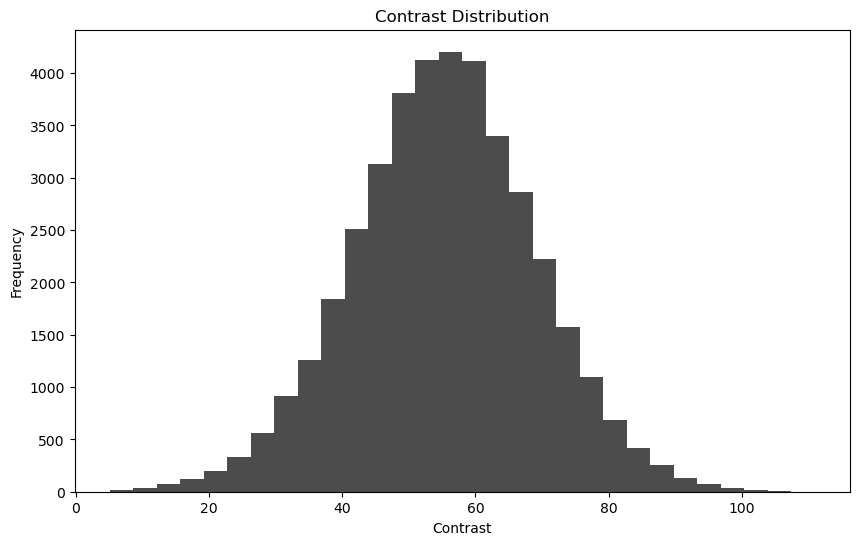

In [10]:
# Analyze the contrast distribution of images to understand the overall contrast levels.

def analyze_contrast_distribution(directory):
    contrast_values = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    contrast_values.append(np.std(gray_img))
    
    plt.figure(figsize=(10, 6))
    plt.hist(contrast_values, bins=30, color='black', alpha=0.7)
    plt.title('Contrast Distribution')
    plt.xlabel('Contrast')
    plt.ylabel('Frequency')
    plt.show()

# Analyze contrast distribution in the training directory
analyze_contrast_distribution(train_dir)

### Image Brightness Distribution

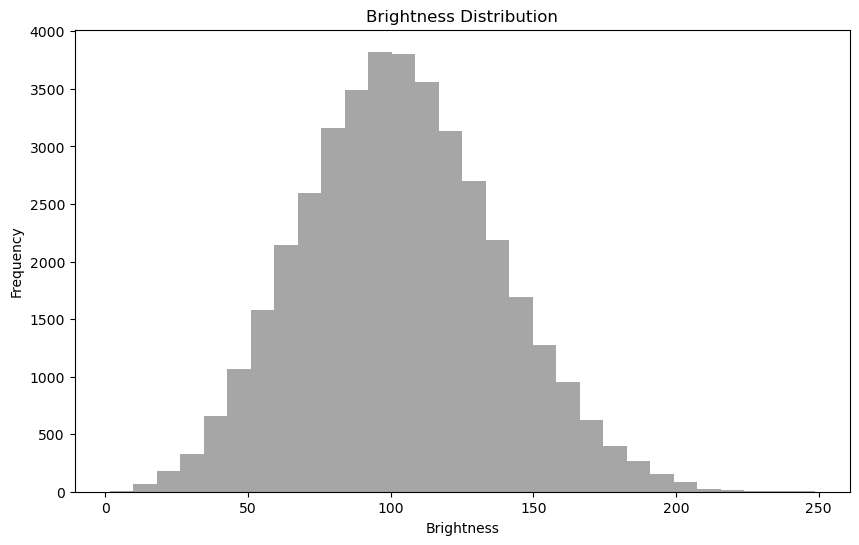

In [11]:
# Analyze the brightness distribution of images to understand the overall lighting conditions.

def analyze_brightness_distribution(directory):
    brightness_values = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    brightness_values.append(np.mean(gray_img))
    
    plt.figure(figsize=(10, 6))
    plt.hist(brightness_values, bins=30, color='gray', alpha=0.7)
    plt.title('Brightness Distribution')
    plt.xlabel('Brightness')
    plt.ylabel('Frequency')
    plt.show()

# Analyze brightness distribution in the training directory
analyze_brightness_distribution(train_dir)

## Preprocessing

In [9]:
# Set parameters for image preprocessing
image_size = (150, 150)
batch_size = 32

# Helper function to create ImageDataGenerators
def create_data_generators(train_dir, val_dir, test_dir, custom_augmentation=False):
    if custom_augmentation:
        datagen_class = CustomImageDataGenerator
    else:
        datagen_class = ImageDataGenerator

    train_datagen = datagen_class(
        rescale=1.0 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )

    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
    )

    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False,
    )

    return train_generator, val_generator, test_generator

# Custom ImageDataGenerator with histogram equalization
class CustomImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, *args, **kwargs):
        generator = super().flow_from_directory(*args, **kwargs)
        while True:
            batch_x, batch_y = next(generator)
            batch_x = np.array([equalize_image(img) for img in batch_x])
            yield batch_x, batch_y

# Function for histogram equalization
def equalize_image(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    l_eq = cv2.equalizeHist((l * 255).astype(np.uint8))
    lab_eq = cv2.merge((l_eq, a, b))
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

# Function to display preprocessed images
def display_preprocessed_images(generator, num_samples=5):
    plt.figure(figsize=(10, 10))
    img_batch, label_batch = next(generator)
    for i in range(min(num_samples, len(img_batch))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_batch[i])
        plt.title(f"Label: {label_batch[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Function to extract HOG features
def extract_hog_features(image):
    gray_image = color.rgb2gray(image)
    hog_features = hog(
        gray_image,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=False,
    )
    return hog_features

# Function to load images and extract HOG features
def load_images_and_extract_features(folder, valid_extensions=None):
    if valid_extensions is None:
        valid_extensions = [".jpg", ".jpeg", ".png", ".bmp"]

    features, labels = [], []
    for filename in os.listdir(folder):
        if any(filename.lower().endswith(ext) for ext in valid_extensions):
            img_path = os.path.join(folder, filename)
            img = io.imread(img_path)
            if img is not None:
                features.append(extract_hog_features(img))
                labels.append(filename.split("_")[0])  # Assuming "label_image.jpg"
        else:
            print(f"Skipped file: {filename}")

    return np.array(features), np.array(labels)

In [10]:
# Create data generators
train_generator, val_generator, test_generator = create_data_generators(train_dir, val_dir, test_dir)

Found 40002 images belonging to 2 classes.
Found 12360 images belonging to 2 classes.
Found 5227 images belonging to 2 classes.


In [11]:
# Load images and extract features
folder_path = train_dir  # Change to your image directory
train_features, train_labels = load_images_and_extract_features(folder_path)

Skipped file: fake
Skipped file: real


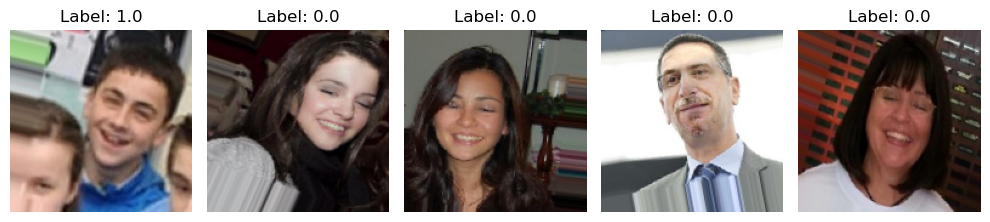

In [12]:
# Display preprocessed images from training set
display_preprocessed_images(train_generator, num_samples=5)

In [13]:
# If necessary, flatten the features
train_features = np.array(train_features)

### Feature Extraction

In [14]:
# Function to load images and labels
def load_images_and_labels(dataset_dir, target_size=(64, 64), classes=None):
    images, labels = [], []
    if classes is None:
        classes = os.listdir(dataset_dir)  # Use all subdirectories as classes

    for label in classes:
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                img = load_img(img_path, target_size=target_size)
                images.append(img_to_array(img))
                labels.append(label)

    return np.array(images), np.array(labels)

# Function to flatten image data
def flatten_images(images):
    n_samples, height, width, channels = images.shape
    return images.reshape(n_samples, -1)

# Function to plot explained variance by PCA components
def plot_explained_variance(pca, threshold=0.95):
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'{int(threshold * 100)}% Variance Threshold')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot t-SNE results
def plot_tsne(X_tsne, labels, label_encoder):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Class Label')
    plt.title('t-SNE Visualization of PCA-Reduced Image Data')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid()
    plt.show()

# Main Execution
dataset_dir = r'D:\Documents\cnn\Data Set 1\train'
classes = ['real', 'fake']  

In [15]:
# Load images and labels
X, y = load_images_and_labels(dataset_dir, target_size=(64, 64), classes=classes)

In [18]:
# Flatten the image data
X_flat = flatten_images(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

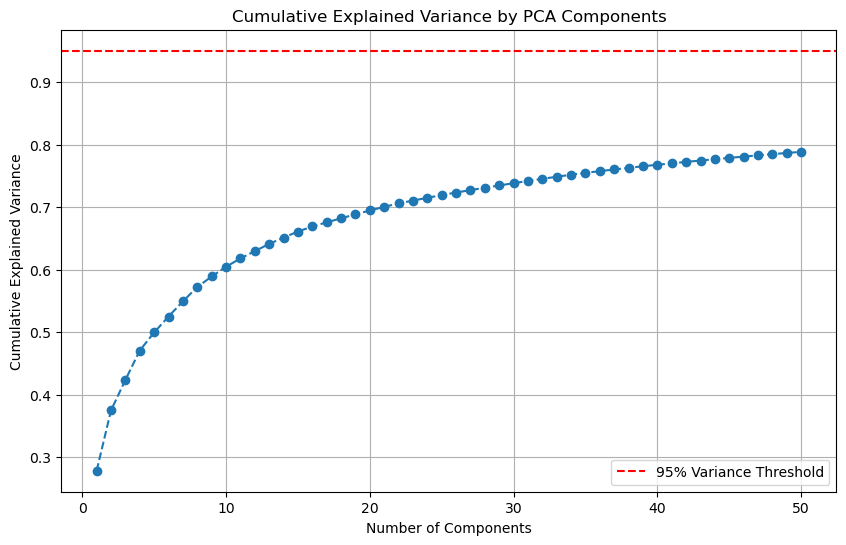

In [19]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_flat)

# Plot explained variance
plot_explained_variance(pca)

## Model Building

In [4]:
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [5]:
def create_model(model_type):
    if model_type == "custom_cnn":
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
    elif model_type == "inception":
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        base_model.trainable = False
    elif model_type == "mobilenet":
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        base_model.trainable = False

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_metric]
    )
    return model

In [6]:
def train_model(model, train_gen, val_gen, model_name):
    print(f"Training {model_name} for 20 epochs...")
    steps_per_epoch = train_gen.samples // train_gen.batch_size
    validation_steps = val_gen.samples // val_gen.batch_size
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )
    return history

In [7]:
custom_cnn_model = create_model("custom_cnn")
cnn_history = train_model(custom_cnn_model, train_generator, val_generator, "Custom CNN")

inception_model = create_model("inception")
inception_history = train_model(inception_model, train_generator, val_generator, "Inception V3")

mobilenet_model = create_model("mobilenet")
mobilenet_history = train_model(mobilenet_model, train_generator, val_generator, "MobileNetV2")

Training Custom CNN for 100 epochs...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 829s 660ms/step - accuracy: 0.6497 - f1_metric: 0.4782 - loss: 0.6148 - precision: 0.6456 - recall: 0.6598 - val_accuracy: 0.7573 - val_f1_metric: 0.5157 - val_loss: 0.5062 - val_precision: 0.7401 - val_recall: 0.7953
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.7500 - f1_metric: 0.4038 - loss: 0.5996 - precision: 0.7500 - recall: 0.6429 - val_accuracy: 0.7544 - val_f1_metric: 0.5303 - val_loss: 0.5180 - val_precision: 0.7242 - val_recall: 0.8242
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 883s 706ms/step - accuracy: 0.8357 - f1_metric: 0.5008 - loss: 0.3698 - precision: 0.8330 - recall: 0.8411 - val_accuracy: 0.8353 - val_f1_metric: 0.5189 - val_loss: 0.3628 - val_precision: 0.8098 - val_recall: 0.8778
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.8438 - f1_metric: 0.3533 - loss: 0.2311 - precision: 0.9000 - recall: 0.6923 - val_accuracy: 0.8383 - val_f1_metri

## Evaluation

In [15]:
# Function to summarize model performance
def summarize_model_performance(y_true, y_pred, model_name):
    y_pred_classes = np.round(y_pred)  # Convert probabilities to class labels
    accuracy = np.mean(y_pred_classes == y_true)
    precision = precision_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes)
    
    print(f"{model_name} Performance Summary:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")

In [8]:
# Plot training and validation accuracy
def plot_accuracy(histories, model_names):
    plt.figure(figsize=(10, 6))
    for history, model_name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{model_name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{model_name} Val Accuracy', linestyle='--')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [9]:
# Plot training and validation loss
def plot_loss(histories, model_names):
    plt.figure(figsize=(10, 6))
    for history, model_name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{model_name} Val Loss', linestyle='--')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

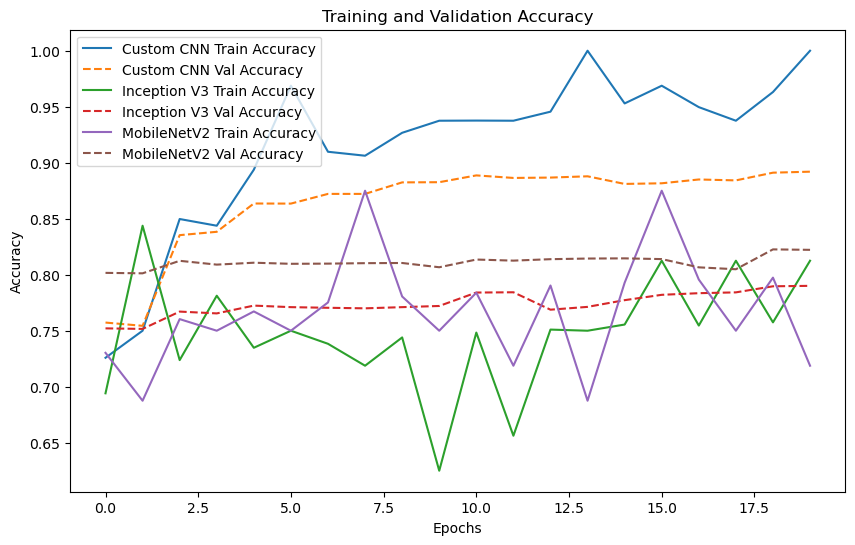

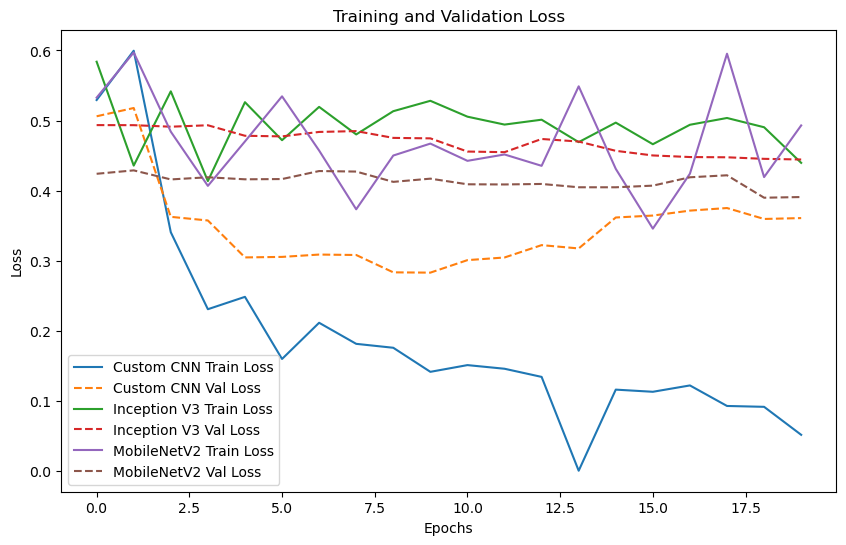

In [10]:
# Plot accuracy and loss for all models
plot_accuracy([cnn_history, inception_history, mobilenet_history], ["Custom CNN", "Inception V3", "MobileNetV2"])
plot_loss([cnn_history, inception_history, mobilenet_history], ["Custom CNN", "Inception V3", "MobileNetV2"])

In [16]:
# Get true labels
y_true = test_generator.classes

# Predictions
y_pred_cnn = custom_cnn_model.predict(test_generator).flatten()
y_pred_inception = inception_model.predict(test_generator).flatten()
y_pred_mobilenet = mobilenet_model.predict(test_generator).flatten()

# Summarize model performance
summarize_model_performance(y_true, y_pred_cnn, 'Custom CNN')
summarize_model_performance(y_true, y_pred_inception, 'Inception V3')
summarize_model_performance(y_true, y_pred_mobilenet, 'MobileNetV2')


164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 569ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 120s 721ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 79s 478ms/step
Custom CNN Performance Summary:
Accuracy: 0.80
Precision: 0.78
Recall: 0.85
F1 Score: 0.81

Inception V3 Performance Summary:
Accuracy: 0.75
Precision: 0.80
Recall: 0.65
F1 Score: 0.72

MobileNetV2 Performance Summary:
Accuracy: 0.69
Precision: 0.84
Recall: 0.48
F1 Score: 0.61



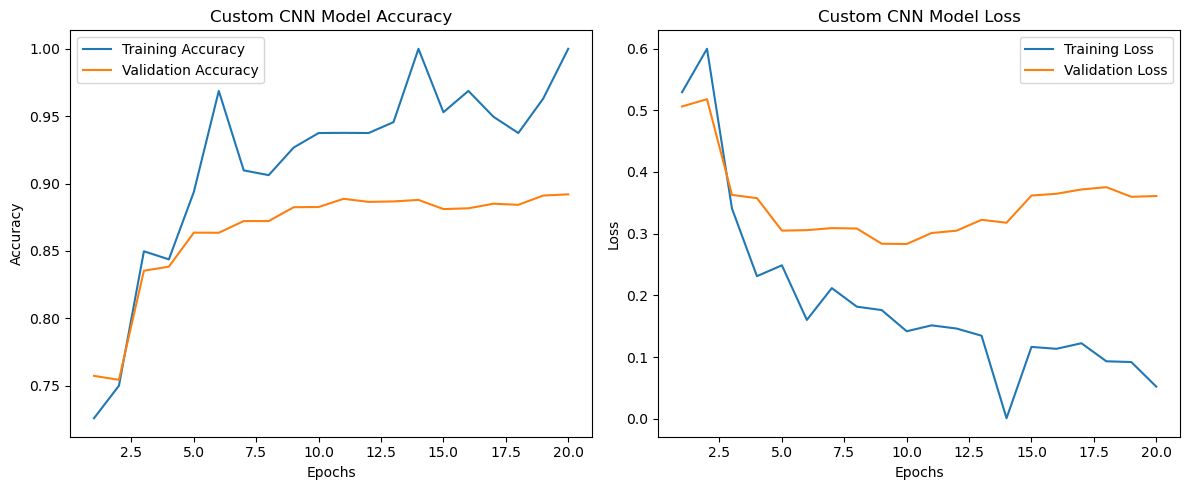

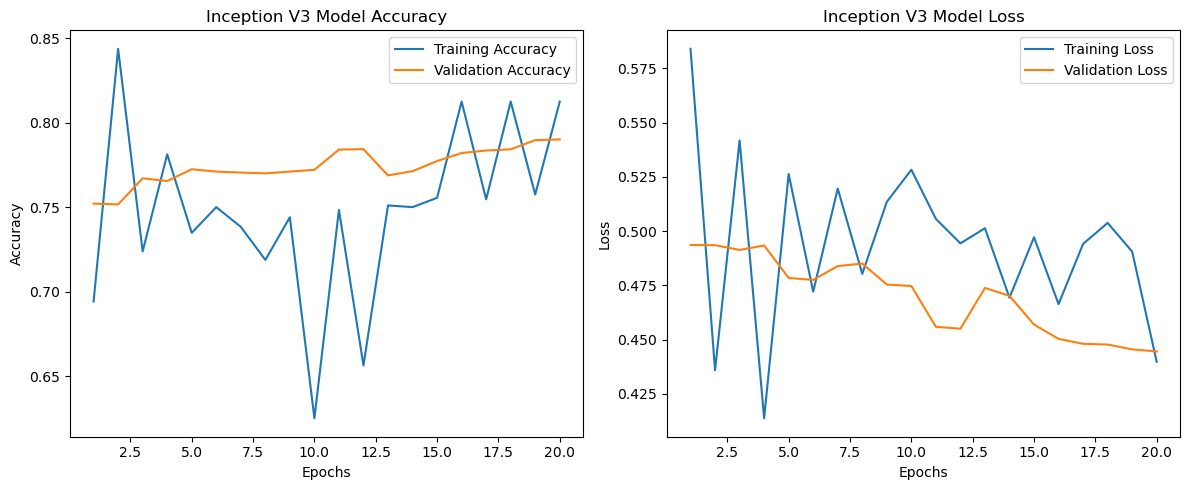

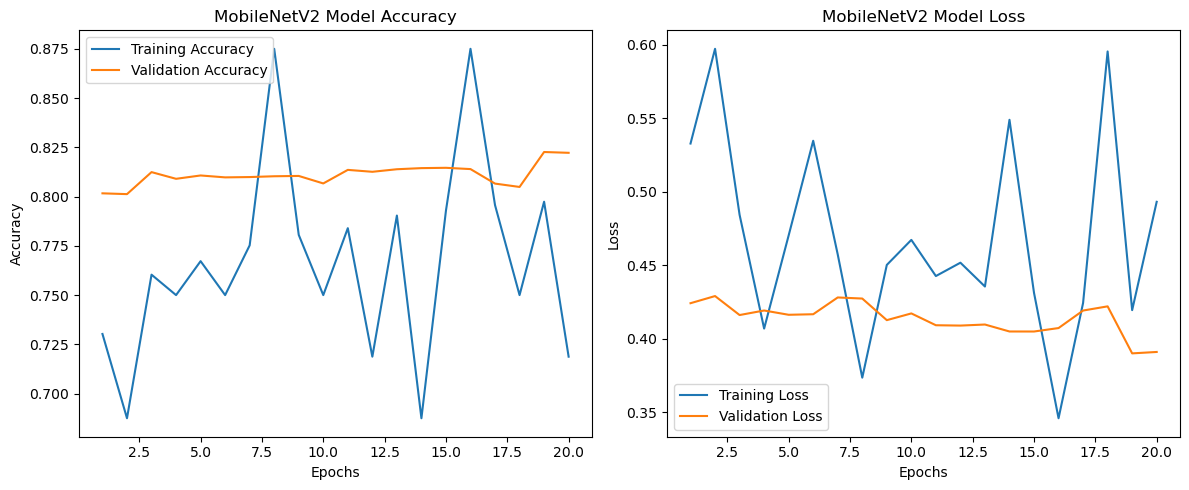

In [17]:
# Plot accuracy and loss
def plot_accuracy_loss(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting accuracy and loss for each model
plot_accuracy_loss(cnn_history, "Custom CNN")
plot_accuracy_loss(inception_history, "Inception V3")
plot_accuracy_loss(mobilenet_history, "MobileNetV2")

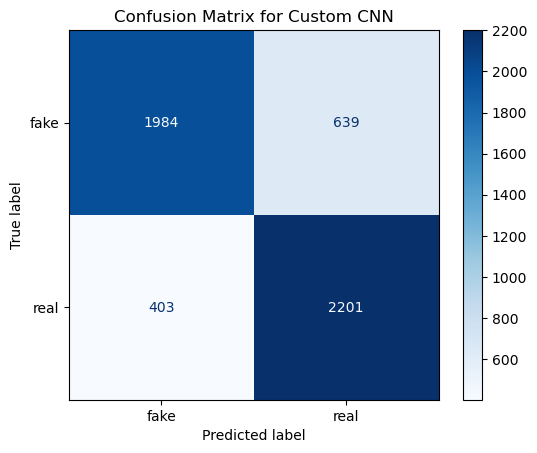

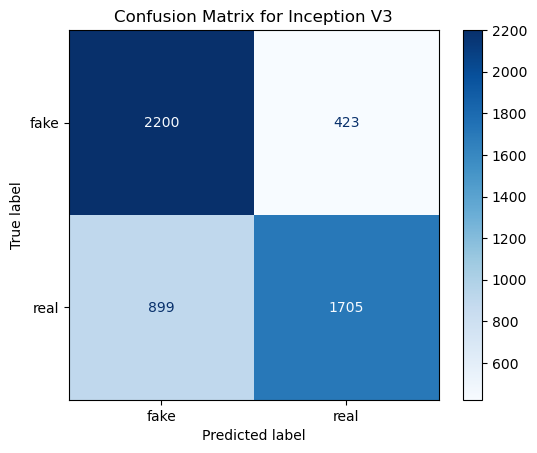

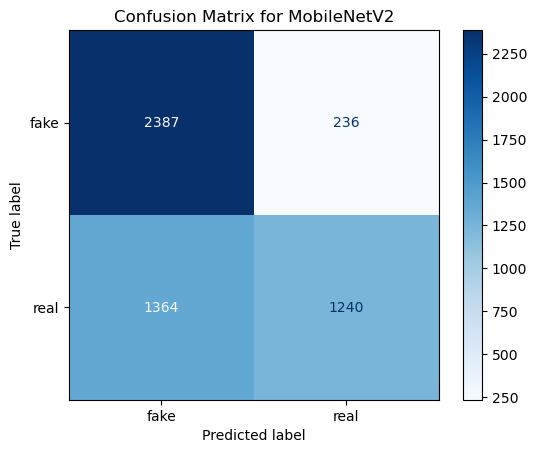

In [18]:
# Function to compute confusion matrix and plot
def plot_confusion_matrix(y_true, y_pred, model_name):
    y_pred_classes = np.round(y_pred)  # Convert probabilities to class labels
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_true, y_pred_cnn, 'Custom CNN')
plot_confusion_matrix(y_true, y_pred_inception, 'Inception V3')
plot_confusion_matrix(y_true, y_pred_mobilenet, 'MobileNetV2')

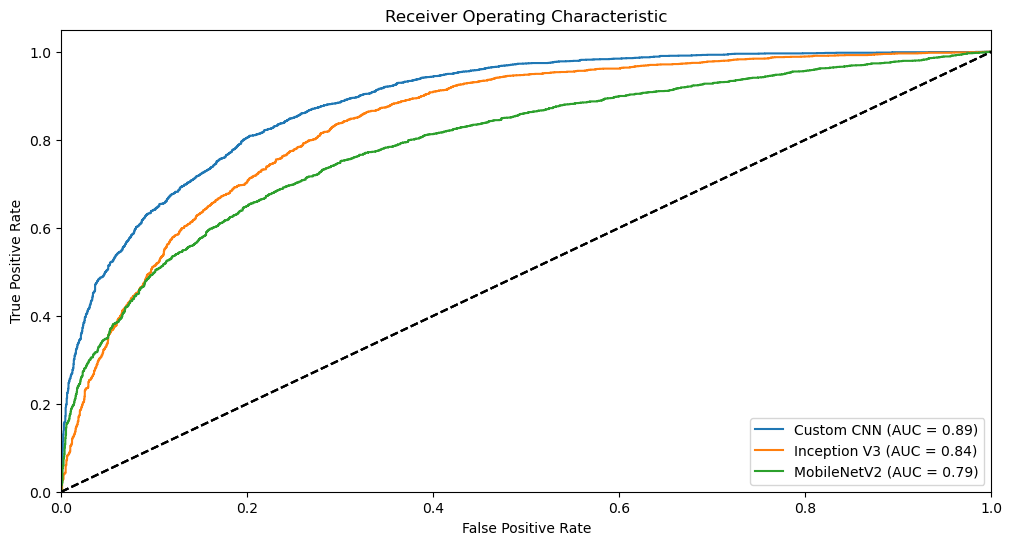

In [19]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

# Plot ROC curves for each model
plt.figure(figsize=(12, 6))
plot_roc_curve(y_true, y_pred_cnn, 'Custom CNN')
plot_roc_curve(y_true, y_pred_inception, 'Inception V3')
plot_roc_curve(y_true, y_pred_mobilenet, 'MobileNetV2')
plt.show()